# Inverse Problem Solver  

# Part 1. Training

This notebook contains the main code to  train solver deeep network based

In [1]:
!pip install plotly

In [2]:
import plotly
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


We need several functions defined before.
The first one is paramenrs generator - GAN

In [3]:
def PhysWorld(var_par, Trib, accell_g, vis):
    dt=0.01
    Times=10
    TN=np.int(Times/dt)
    kdivm=Trib
    x=np.zeros(TN+2)
    y=np.zeros(TN+2)
    v_x=np.zeros(TN+2)
    v_y=np.zeros(TN+2)
    v_x[0]=var_par[0]*np.cos(var_par[1])
    v_y[0]=var_par[0]*np.sin(var_par[1])
    
    i=0
    while ((y[i])>=0):
        v_x[i+1]=v_x[i]-kdivm*v_x[i]*np.sqrt(v_x[i]**2+v_y[i]**2)*dt
        v_y[i+1]=v_y[i]-(accell_g+kdivm*v_y[i]*np.sqrt(v_x[i]**2+v_y[i]**2))*dt
        x[i+1]=x[i]+0.5*(v_x[i]+v_x[i+1])*dt
        y[i+1]=y[i]+0.5*(v_y[i]+v_y[i+1])*dt
        #print(y[i+1])
        i=i+1
    if vis==True:
        fig = px.scatter(x=x, y=y)
        fig.show()
    
        
    sensor_data=np.array([x[i-1],v_x[i]/v_y[i]])
    return sensor_data

In [4]:
def sim_batch(params, batch_size):
    for i in range(batch_size):
        var_par=params[i,:]
        sensor_data=PhysWorld(var_par, Trib, accell_g, vis=False)
        #print(sensor_data)
        if i ==0:
            Sens_data=sensor_data
        else:
            Sens_data=np.vstack([Sens_data,sensor_data])
    return Sens_data 

Now we can create the main model to solve inverse problem

In [5]:
#Build model
s_model = Sequential()
s_model.add(Dense(2, input_dim=2, kernel_initializer='normal', activation='relu'))
s_model.add(Dense(2, kernel_initializer='normal', activation='relu'))
s_model.add(Dense(2, kernel_initializer='normal'))
# Compile model
s_model.compile(loss='mean_squared_error', optimizer='adam')
s_model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 6         
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


### Main loop to train the s-model

In [6]:
#Physical world parametrs
accell_g=9.8
Trib=0.25

In [7]:
# learning batch size
batch_size=30
#how many epochs we use
epochs=3

In [8]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from keras.layers import LeakyReLU
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

In [10]:
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

In [17]:
# Recreate the exact same model purely from the file
generator = load_model('var_par_generator.h5')

/opt/conda/lib/python3.6/site-packages/keras/models.py:252: UserWarning:

No training configuration found in save file: the model was *not* compiled. Compile it manually.



In [12]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


In [13]:
treshold=5
latent_dim=5

epochs= 0


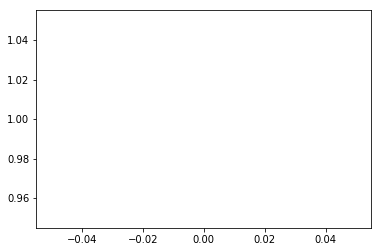

In [18]:
# Main loop
Loss=[1] 
history=1
e=0
while history >=treshold:
    for _ in tqdm(range(batch_size)):
        # Generate batch of parameters
        generated_params,y = generate_fake_samples(generator, latent_dim, batch_size)
        print("params",generated_params )
        #Simulate sensor data 
        Sensor_data=sim_batch(generated_params, batch_size)
        
        print('sensors', Sensor_data)
            
        #train the deep network. 
        history=s_model.train_on_batch(Sensor_data, generated_params)
        Loss=np.vstack([Loss,history])
        e=e+1    
print('epochs=', e)           
          
plt.plot(Loss)
plt.show()

In [15]:
e

3362

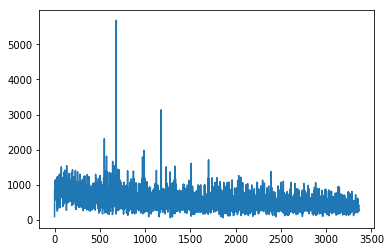

In [16]:
plt.plot(Loss)
plt.show()

In [ ]:
s_model.save('inv_prob_nn.h5')

## End of Part 1.

# Part 2. Inference : Solving the inverse problem 

In [ ]:
import plotly
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

In [ ]:
def load_data_s():
    df=pd.read_csv('TrueData.csv', sep=',')
    x_train = df.values
    return x_train

In [ ]:
def var_par_vis (var_par):
    fig = ff.create_quiver(np.zeros(len(var_par)),np.zeros(len(var_par)), var_par[:,0]*np.cos(var_par[:,1]), var_par[:,0]*np.sin(var_par[:,1]),scale=.25,
                       arrow_scale=.1,
                       name='quiver',
                       line=dict(width=1))
    fig.show()

In [ ]:
# Recreate the exact same inverse problem neural network model purely from the file
s_model = load_model('inv_prob_nn.h5')

In [ ]:
def PhysWorld(var_par, Trib, accell_g, vis):
    dt=0.001
    kdivm=Trib
    x=np.zeros(1)
    y=np.zeros(1)
    v_x=np.empty(0)
    v_y=np.empty(0)
    v_x_new=var_par[0]*np.cos(var_par[1])
    v_y_new=var_par[0]*np.sin(var_par[1])
    v_x=np.append(v_x,v_x_new)
    v_y=np.append(v_y,v_y_new)
    #DE Solving
    i=0
    while ((y[i])>=0):
        v_x_new=v_x[i]-kdivm*v_x[i]*np.sqrt(v_x[i]**2+v_y[i]**2)*dt
        v_x=np.append(v_x,v_x_new)
        v_y_new=v_y[i]-(accell_g+kdivm*v_y[i]*np.sqrt(v_x[i]**2+v_y[i]**2))*dt
        v_y=np.append(v_y,v_y_new)
        x_new=x[i]+0.5*(v_x[i]+v_x_new)*dt
        y_new=y[i]+0.5*(v_y[i]+v_y_new)*dt
        x=np.append(x,x_new)
        y=np.append(y,y_new)
        i=i+1
    if vis==True:
        fig = px.scatter(x=x, y=y)
        fig.show()
    sensor_data=np.array([x_new,np.arctan2(v_y_new, v_x_new)])

    return sensor_data

In [ ]:
accell_g=9.8
Trib=0.25

In [ ]:
params_true = load_data_s()

In [ ]:
params_true[0:1,:]

In [ ]:
params_true[0:1,0]*np.cos(params_true[0:1,1])/4

In [ ]:
params_true[0:1,0]*np.sin(params_true[0:1,1])/4

In [ ]:
var_par_vis(params_true[0:1,:])

In [ ]:
sensors=PhysWorld(params_true[0,:], Trib, accell_g, True)

In [ ]:
sensors=sensors.reshape(1,2)
sensors

In [ ]:
par_predict=s_model.predict(sensors)

In [ ]:
par_predict